In [1]:
# Getting the data generators for the training and validation sets
import os
import sys

module_path = os.path.abspath('../utils')
print("Adding to sys.path:", module_path)
sys.path.append(module_path)

from data_prep import get_data_generators
train_gen, valid_gen, full_gen, _ = get_data_generators('../data/pokemon.csv', '../data/pokemon-img/pokemon/pokemon/')

Adding to sys.path: c:\Users\halod\Documents\Projects\poke_classy\utils

{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Found 576 validated image filenames.
Found 145 validated image filenames.
Found 721 validated image filenames.


(32, 128, 128, 3) (32, 18)


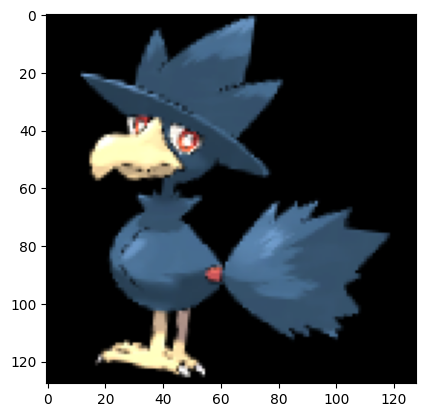

In [2]:
import matplotlib.pyplot as plt
x, y = next(train_gen)
print(x.shape, y.shape)

plt.imshow(x[2])
plt.show()

In [5]:
# defining the model based on the base model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy, AUC

model = models.Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),


    Flatten(),
    Dense(64, activation='relu'),
    Dense(18)
])

model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(from_logits=True),  # For multi-label
    metrics=[
        AUC(name='auc', multi_label=True),TopKCategoricalAccuracy(k=2)]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 batch_normalization_4 (Bat  (None, 126, 126, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_5 (Bat  (None, 61, 61, 32)        128       
 chNormalization)                                                
                                                      

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',patience=15, verbose=0
)

history = model.fit(train_gen, 
                   epochs=500, 
                   validation_data=valid_gen, 
                   callbacks=[early_stopping], 
                   verbose=1)


Epoch 1/500
18/18 [==============================] - 4s 178ms/step - loss: 0.4805 - auc: 0.5116 - top_k_categorical_accuracy: 0.1163 - val_loss: 0.7229 - val_auc: 0.5249 - val_top_k_categorical_accuracy: 0.1103
Epoch 2/500
18/18 [==============================] - 3s 154ms/step - loss: 0.3432 - auc: 0.5012 - top_k_categorical_accuracy: 0.1267 - val_loss: 0.7757 - val_auc: 0.5390 - val_top_k_categorical_accuracy: 0.1241
Epoch 3/500
18/18 [==============================] - 5s 258ms/step - loss: 0.3215 - auc: 0.5039 - top_k_categorical_accuracy: 0.1719 - val_loss: 0.7838 - val_auc: 0.5364 - val_top_k_categorical_accuracy: 0.1103
Epoch 4/500
18/18 [==============================] - 5s 252ms/step - loss: 0.3075 - auc: 0.5038 - top_k_categorical_accuracy: 0.1615 - val_loss: 0.7555 - val_auc: 0.5467 - val_top_k_categorical_accuracy: 0.1103
Epoch 5/500
18/18 [==============================] - 4s 243ms/step - loss: 0.2990 - auc: 0.5040 - top_k_categorical_accuracy: 0.1910 - val_loss: 0.7166 - va

23/23 - 1s - loss: 0.2446 - auc: 0.5655 - top_k_categorical_accuracy: 0.4202 - 1s/epoch - 56ms/step


Loss on test set 0.245,  Categorical accuracy on test set 0.420, AUC 0.565


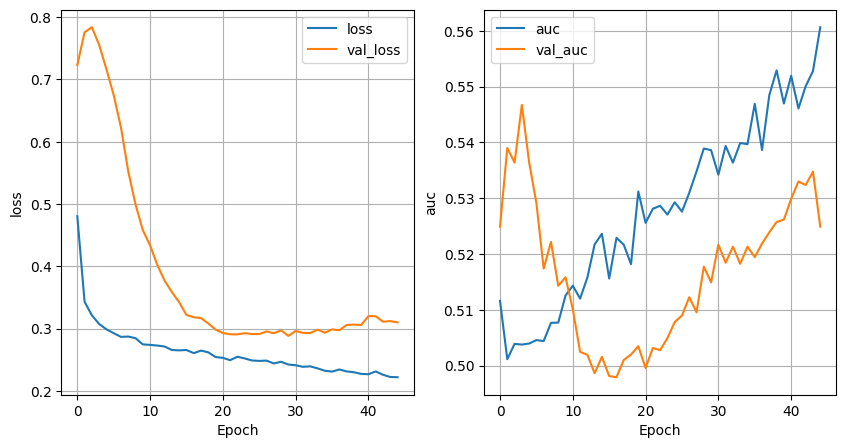

In [7]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

test_loss, auc,test_acc = model.evaluate(full_gen, verbose=2); 
print("\n\nLoss on test set {:.3},  Categorical accuracy on test set {:.3f}, AUC {:.3f}".format(test_loss, test_acc, auc))

In [6]:

model.save('../models/poke_type_noROTATE_v2.3(0.77acc).h5')
print("✅ Model saved")

✅ Model saved


c:\Users\halod\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
